<a href="https://colab.research.google.com/github/nazeer-18/Gold-Price-Prediction-using-Deep-Learning/blob/main/Gold_Price_Prediction_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout, LSTM, GRU

In [3]:
df = pd.read_csv('/content/drive/MyDrive/neural_paper/Gold Price (2013-2023).csv')

In [4]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


In [6]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [9]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8


In [10]:
df.duplicated().sum()

0

In [11]:
df.isnull().sum().sum()

0

In [12]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [13]:
test_size = df[df.Date.dt.year>=2021].shape[0]
test_size

518

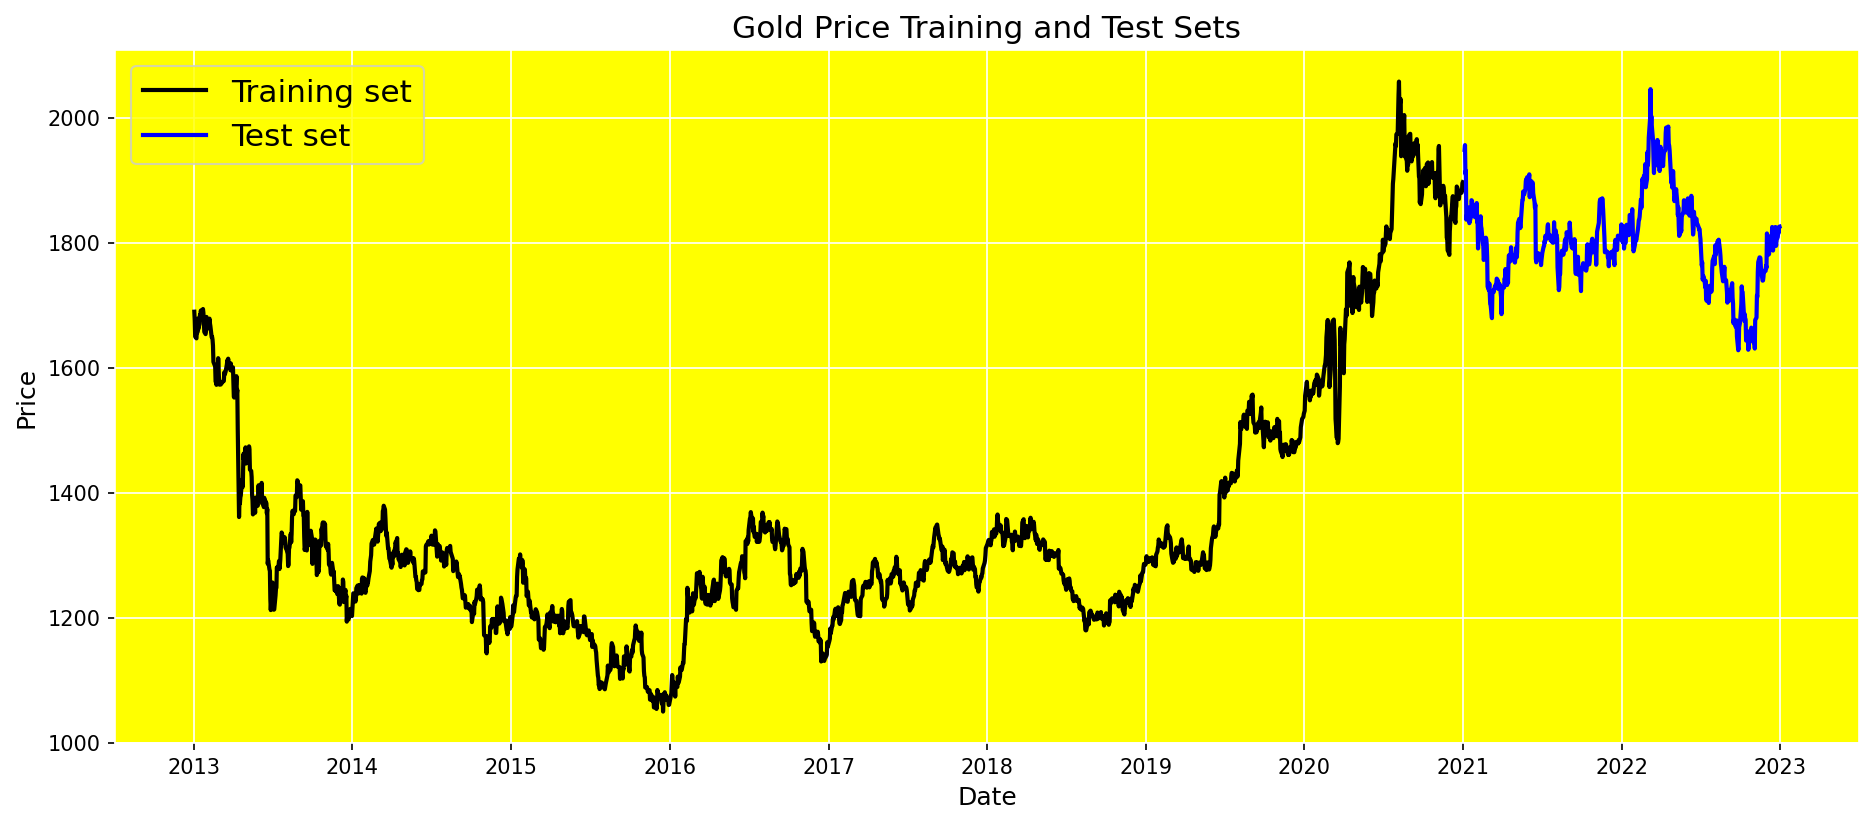

In [14]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [15]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [16]:
window_size = 60

In [17]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [18]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [19]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [20]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [21]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [22]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [23]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2005, 60, 1)
y_train Shape:  (2005, 1)
X_test Shape:   (518, 60, 1)
y_test Shape:   (518, 1)


In [24]:
def define_gru_model():
    input1 = Input(shape=(window_size,1))
    x = GRU(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = GRU(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = GRU(units=64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    gru_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[gru_output])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()

    return model

gru_model = define_gru_model()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 60, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 60, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,897 (253.50 KB)

 Trainable params: 64,897 (253.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 60, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 60, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,897 (253.50 KB)

 Trainable params: 64,897 (253.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0091 - val_loss: 0.0025
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.5033e-04 - val_loss: 0.0079
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9806e-04 - val_loss: 0.0063
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.0343e-04 - val_loss: 0.0046
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1126e-04 - val_loss: 0.0011
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3784e-04 - val_loss: 0.0037
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.1734e-04 - val_loss: 0.0017
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.9899e-04 - val_loss: 0.0021
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2694e-04 - val_loss: 0.0042
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9394e-04 - val_loss: 0.0037
Epoch 12/50
57/57 ━━━━━━━━━

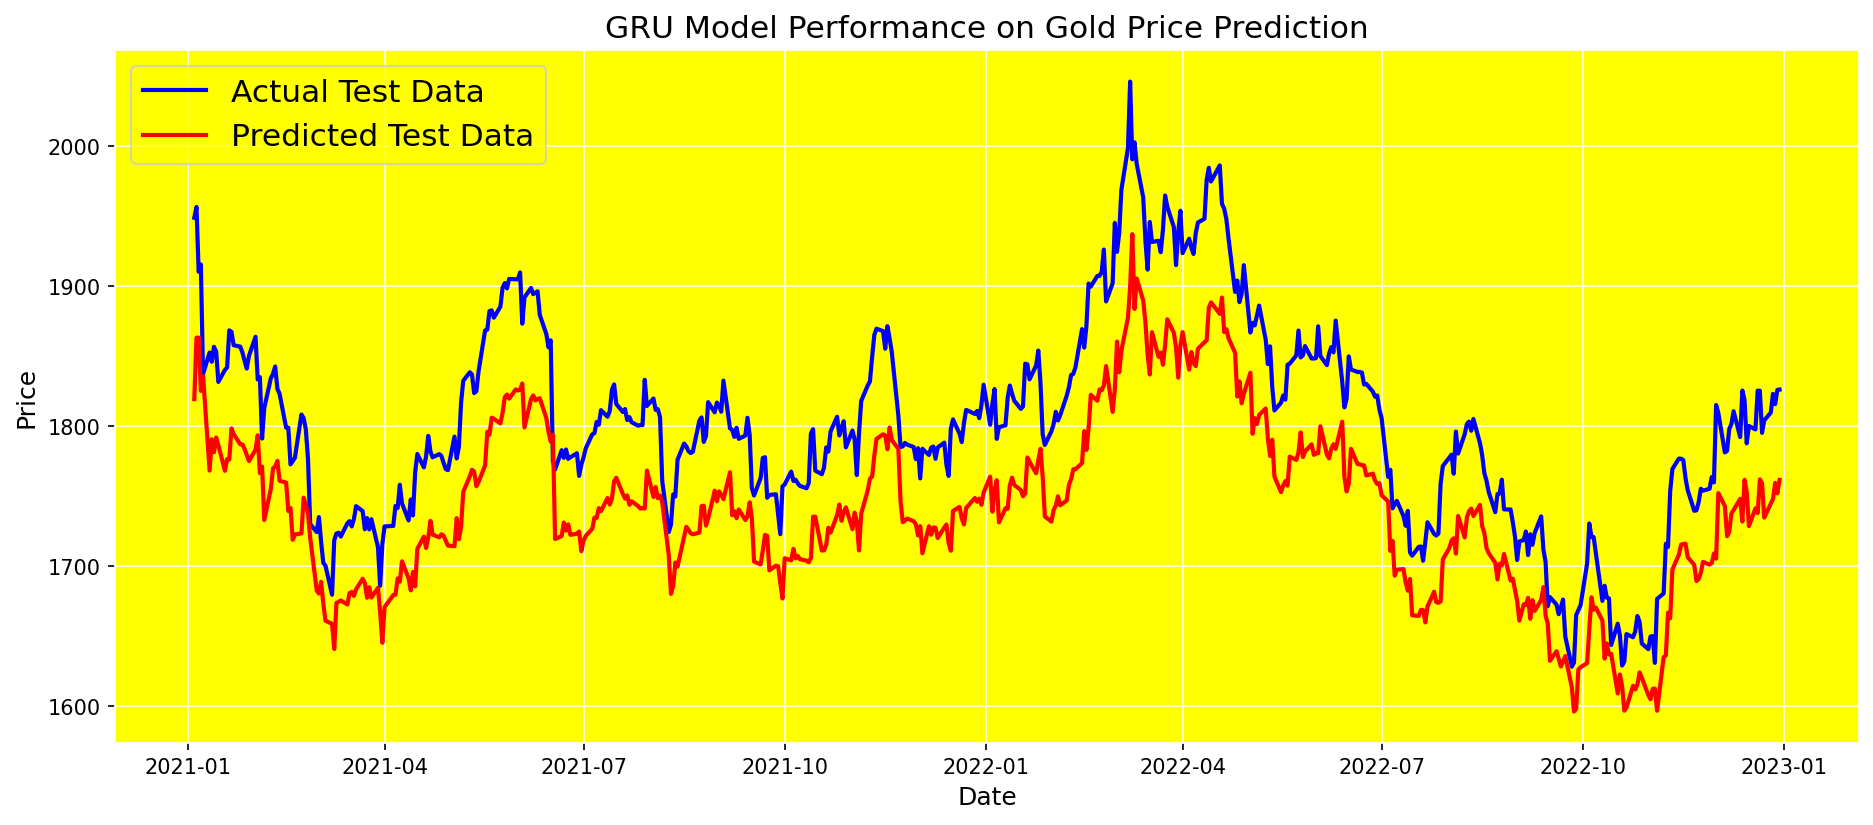

In [25]:
# Train the GRU model
gru_model = define_gru_model()
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate on test data
gru_result = gru_model.evaluate(X_test, y_test)

# Predict on test data
gru_y_pred = gru_model.predict(X_test)

# Calculate MAPE and accuracy
gru_MAPE = mean_absolute_percentage_error(y_test, gru_y_pred)
gru_Accuracy = 1 - gru_MAPE

print("GRU Test Loss:", gru_result)
print("GRU Test MAPE:", gru_MAPE)
print("GRU Test Accuracy:", gru_Accuracy)

# Plot the predictions
gru_y_test_true = scaler.inverse_transform(y_test)
gru_y_test_pred = scaler.inverse_transform(gru_y_pred)

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-test_size:], gru_y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], gru_y_test_pred, color='red', lw=2)
plt.title('GRU Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [26]:
def define_rnn_model():
    input1 = Input(shape=(window_size,1))
    x = tf.keras.layers.SimpleRNN(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.SimpleRNN(units=64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    rnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[rnn_output])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()

    return model

rnn_model = define_rnn_model()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 60, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 60, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0282 - val_loss: 0.3011
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0111 - val_loss: 0.2013
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035 - val_loss: 0.1541
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 0.1265
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - val_loss: 0.1092
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 0.0994
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - val_loss: 0.0926
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.1071e-04 - val_loss: 0.0884
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.8421e-04 - val_loss: 0.0847
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.0980e-04 - val_loss: 0.0814
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.3058e-04 - val_loss: 0.0790
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms

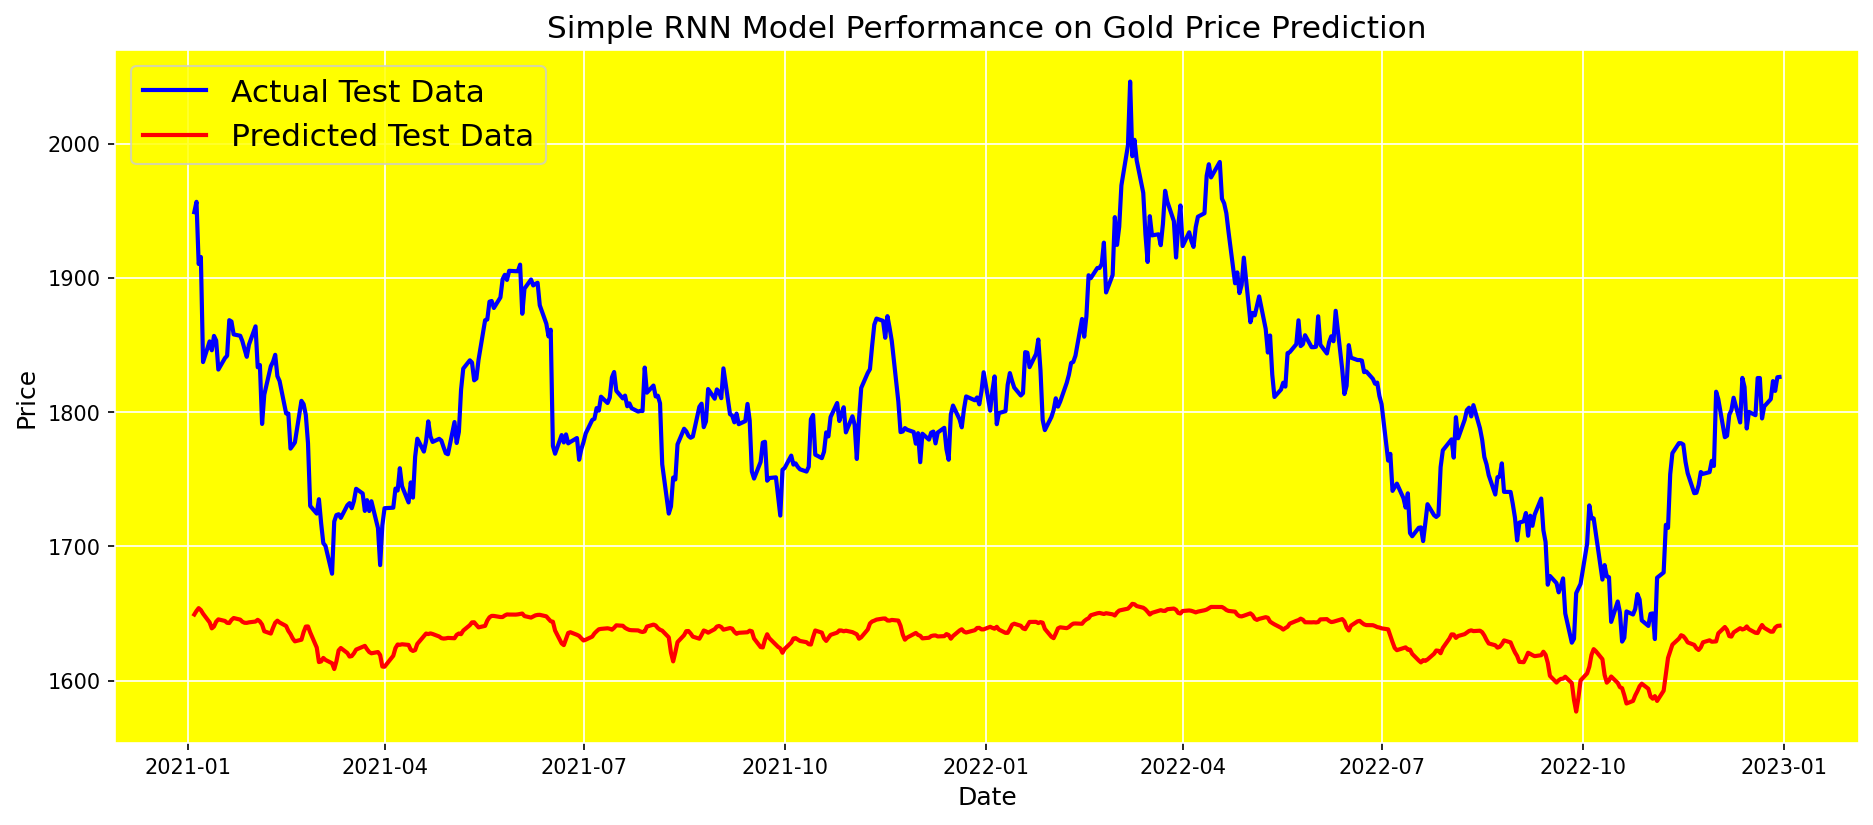

In [27]:
# Train the Simple RNN model
rnn_model = define_rnn_model()
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate on test data
rnn_result = rnn_model.evaluate(X_test, y_test)

# Predict on test data
rnn_y_pred = rnn_model.predict(X_test)

# Calculate MAPE and accuracy
rnn_MAPE = mean_absolute_percentage_error(y_test, rnn_y_pred)
rnn_Accuracy = 1 - rnn_MAPE

print("Simple RNN Test Loss:", rnn_result)
print("Simple RNN Test MAPE:", rnn_MAPE)
print("Simple RNN Test Accuracy:", rnn_Accuracy)

# Plot the predictions
rnn_y_test_true = scaler.inverse_transform(y_test)
rnn_y_test_pred = scaler.inverse_transform(rnn_y_pred)

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-test_size:], rnn_y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], rnn_y_test_pred, color='red', lw=2)
plt.title('Simple RNN Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()


In [28]:
def define_lstm_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2)(x)
    lstm_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[lstm_output])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()

    return model

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,185 (645.25 KB)

 Trainable params: 165,185 (645.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0120 - val_loss: 0.0041
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 0.0067
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.6125e-04 - val_loss: 0.0036
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.4269e-04 - val_loss: 0.0034
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - l

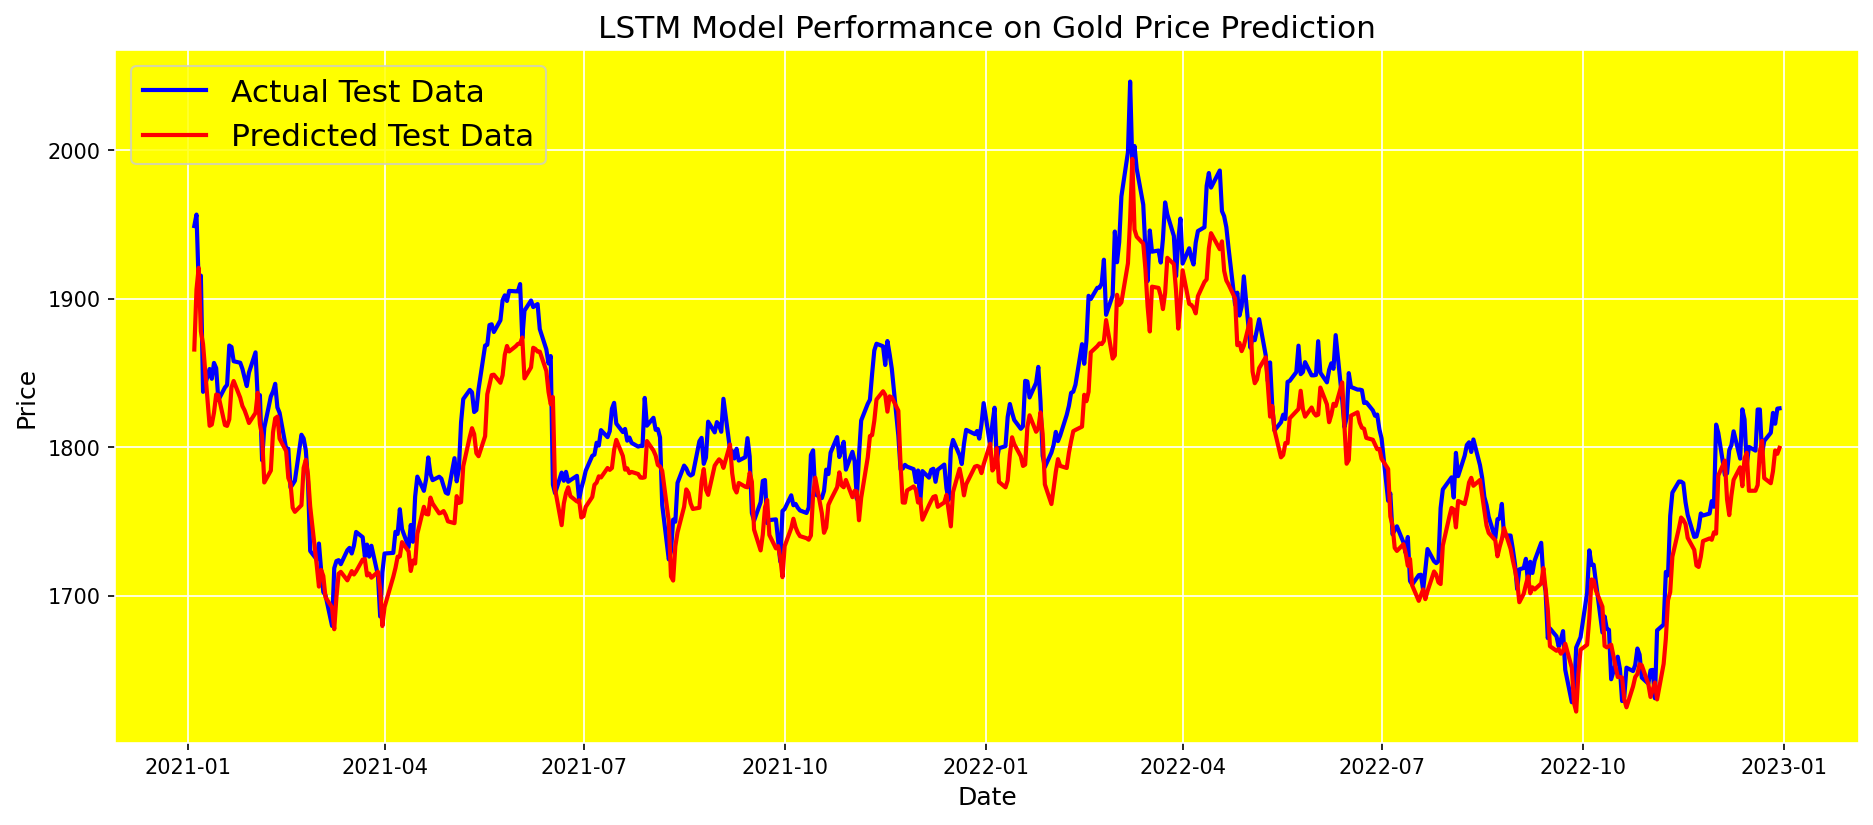

In [29]:
# Train the LSTM model
lstm_model = define_lstm_model()
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate on test data
lstm_result = lstm_model.evaluate(X_test, y_test)

# Predict on test data
lstm_y_pred = lstm_model.predict(X_test)

# Calculate MAPE and accuracy
lstm_MAPE = mean_absolute_percentage_error(y_test, lstm_y_pred)
lstm_Accuracy = 1 - lstm_MAPE

print("LSTM Test Loss:", lstm_result)
print("LSTM Test MAPE:", lstm_MAPE)
print("LSTM Test Accuracy:", lstm_Accuracy)

# Plot the predictions
lstm_y_test_true = scaler.inverse_transform(y_test)
lstm_y_test_pred = scaler.inverse_transform(lstm_y_pred)

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-test_size:], lstm_y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], lstm_y_test_pred, color='red', lw=2)
plt.title('LSTM Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

def define_linear_model(X):
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Create the Linear Regression model
    model = LinearRegression()

    return model, X_scaled, scaler


In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'Price' is the target variable
# Prepare the data (X and y)
df['Previous_Price'] = df['Price'].shift(1)
df = df.dropna()

X = df[['Previous_Price']].values  # Replace with your actual feature(s)
y = df['Price'].values  # Your target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=100)

# Define the model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Predict on test data
y_pred = linear_model.predict(X_test)

# Evaluate the model
linear_mape = mean_absolute_percentage_error(y_test, y_pred)
linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression Test RMSE:", linear_rmse)
print("Linear Regression Test MAPE:", linear_mape)

# Prepare for accuracy calculation
# Set a threshold based on the mean of the training data
threshold = np.mean(y_train)

# Convert predictions into binary classification
y_pred_class = np.where(y_pred > threshold, 0,0)  # 1 if predicted price is greater than threshold, otherwise 0
y_test_class = np.where(y_test > threshold, 0,1)  # Apply the same threshold on y_test

# Calculate accuracy
linear_Accuracy = accuracy_score(y_test_class, y_pred_class)

print("Accuracy:", linear_Accuracy)


Linear Regression Test RMSE: 18.10948319805966
Linear Regression Test MAPE: 0.007367168314860453
Accuracy: 0.3384615384615385


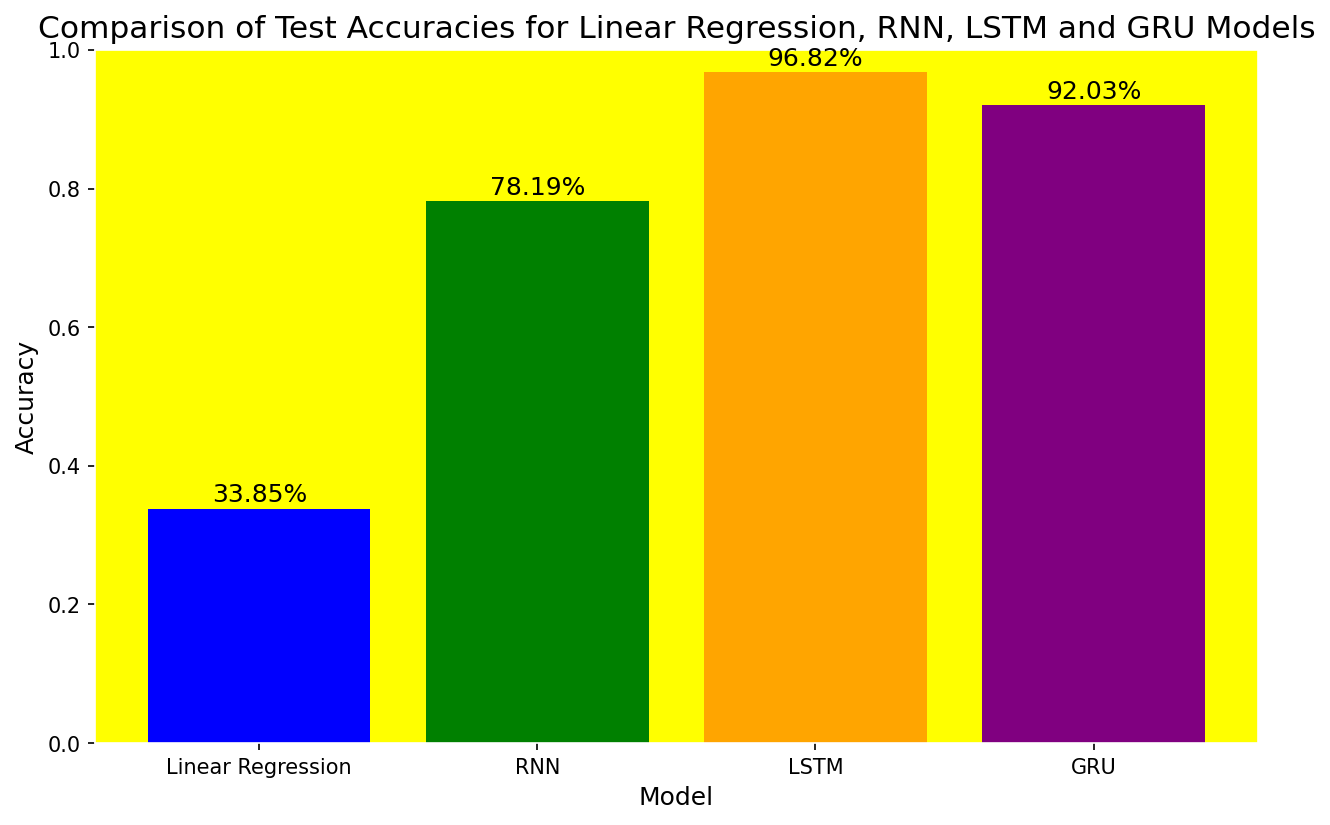

In [32]:
import matplotlib.pyplot as plt

# Define the model names and accuracies
models = ['Linear Regression','RNN', 'LSTM', 'GRU']
accuracies = [linear_Accuracy,rnn_Accuracy,lstm_Accuracy, gru_Accuracy]  # Ensure linear_Accuracy is defined

# Plotting
plt.figure(figsize=(10, 6), dpi=150)
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)  # Accuracy is between 0 and 1

# Adding title and labels
plt.title('Comparison of Test Accuracies for Linear Regression, RNN, LSTM and GRU Models', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Display the values of accuracies on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center', fontsize=12)

plt.show()


X_test shape: (130, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


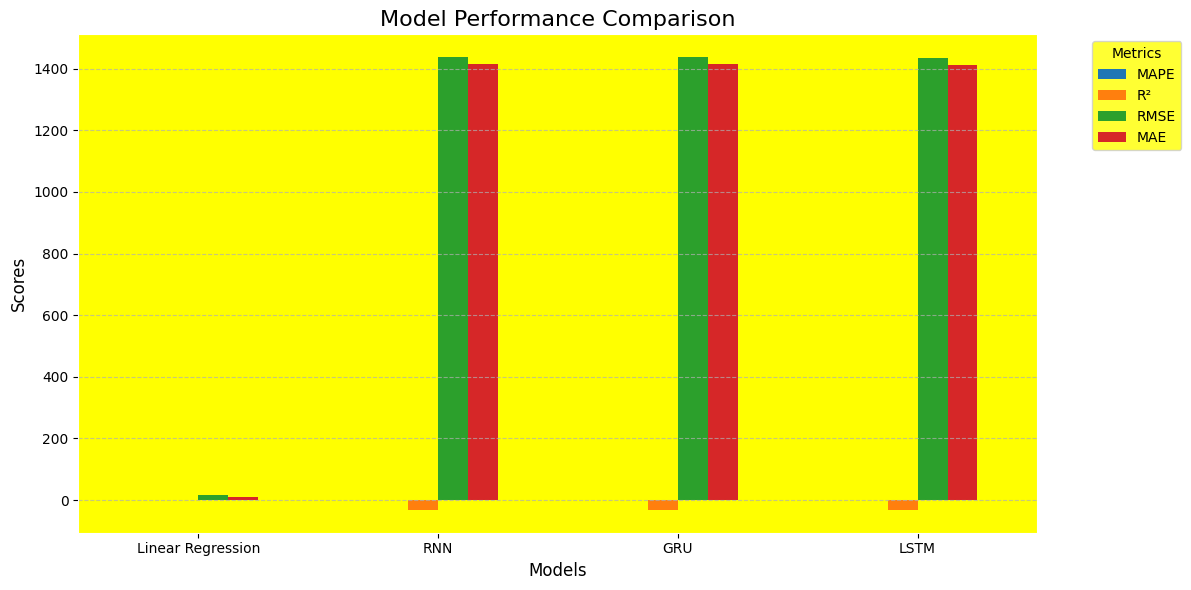

                       MAPE         R²         RMSE          MAE
Linear Regression  0.007367   0.994719    18.109483    10.528950
RNN                0.999557 -32.294046  1437.888365  1416.129963
GRU                0.998552 -32.230901  1436.524187  1414.744803
LSTM               0.997222 -32.147476  1434.719882  1412.912796


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error

# Check the shape of X_test
print("X_test shape:", X_test.shape)

# Reshape X_test for RNN, GRU, and LSTM (if necessary)
time_steps = 1  # Adjust based on your model's requirement
X_test_reshaped = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# Make predictions using your trained models
y_pred_lr = linear_model.predict(X_test)  # Linear Regression predictions
y_pred_rnn = rnn_model.predict(X_test_reshaped)  # RNN predictions
y_pred_gru = gru_model.predict(X_test_reshaped)  # GRU predictions
y_pred_lstm = lstm_model.predict(X_test_reshaped)  # LSTM predictions

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return mape, r2, rmse, mae

# Calculate metrics for each model
metrics = {}
metrics['Linear Regression'] = calculate_metrics(y_test, y_pred_lr)
metrics['RNN'] = calculate_metrics(y_test, y_pred_rnn)
metrics['GRU'] = calculate_metrics(y_test, y_pred_gru)
metrics['LSTM'] = calculate_metrics(y_test, y_pred_lstm)

# Convert metrics into a DataFrame for easier plotting
import pandas as pd

metrics_df = pd.DataFrame(metrics, index=['MAPE', 'R²', 'RMSE', 'MAE']).T
metrics_df.columns = ['MAPE', 'R²', 'RMSE', 'MAE']

# Plot the metrics
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Scores', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print metrics for reference
print(metrics_df)
